# Convolutional Neural Networks

## Project: Writing an Algorithm for Landmark Classification

---

Photo storage and photo sharing services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience with the location data. If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image.

In this notebook, we will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image.

We will utilize the following steps for this purpose.  We can use the links below to navigate the notebook.

* [Step 0](#step0): Downloading Dataset and Installing Python Modules
* [Step 1](#step1): Building a CNN to Classify Landmarks
* [Step 2](#step2): Building a CNN to Classify Landmarks using **Transfer Learning**
* [Step 3](#step3): Writing Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Downloading Dataset and Installing Python Modules

Following is the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip). The landmark images are a subset of the Google Landmarks Dataset v2.
To train CNN, we will unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---
<a id='step1'></a>
## Step 1: Building a CNN to Classify Landmarks

In this step, we will build a CNN model that will attain a test accuracy of at least 20%.
Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. 

### Specifying Data Loaders for the Landmark Dataset

We will use the code cell below to form three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. We will randomly split the images located at `landmark_images/train` to form the train and validation data loaders, and use the images located at `landmark_images/test` to form the test data loader.

We may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If we are interested in augmenting our training and/or validation data, we can check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform).

In [1]:
### Writing data loaders for training, validation, and test sets
## Specifing appropriate transforms, and batch_sizes

import torch
from torchvision import datasets, transforms as T
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

batch_size = 10
valid_size = 0.2

train_transform = T.Compose([ T.Resize((256, 256)),
                              T.RandomRotation(10),
                              T.RandomHorizontalFlip(),
                              T.ToTensor() ])

test_transform = T.Compose([ T.Resize((256, 256)),
                             T.ToTensor() ])

#  ToTensor() - PyTorch automatically converts all images into [0,1]

train_dataset = datasets.ImageFolder('./landmark_images/train/', transform=train_transform)
test_dataset = datasets.ImageFolder('./landmark_images/test/', transform=test_transform)


num_train_data = len(train_dataset)
indices = list(range(num_train_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train_data))
train_idx, valid_idx = indices[split:], indices[:split]

# SubsetRandomSampler - uses randomly select samples from indices
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


**Procedure for preprocessing the data** 

The images are resized by using transforms.Resize which returns the scaled image with the specified size. It is known that deep learning models train faster on small images. After based on research and the recommendation, the size of the output image is chosen to be 256 which is generally used by convention to obtain good results and not exhaust GPU memory.   

The dataset is augmented by randomly rotating by 10 degrees and randomly flipping horizontally. This way, the specified augmentations will be applied every time a sample is loaded and the model will get to see a different set of images in each epoch, this will result in the model improving its generalization better and preventing overfitting. The horizontal flip is selected because the photographs could be taken from both sides horizontally generally. The rotation augmentation is used considering that the photographs taken of the landmark are not always vertically aligned and the degree is selected to be optimal considering that the angle of the taken photograph could not be praticallly too much rotated.  

### Visualizing a Batch of Training Data

We will use the code cell below to retrieve a batch of images from our train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of our data loader is a great way to ensure that our data loading and preprocessing are working as expected.

C:\Users\User\AppData\Local\Temp\ipykernel_14328\1092636631.py:26: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])


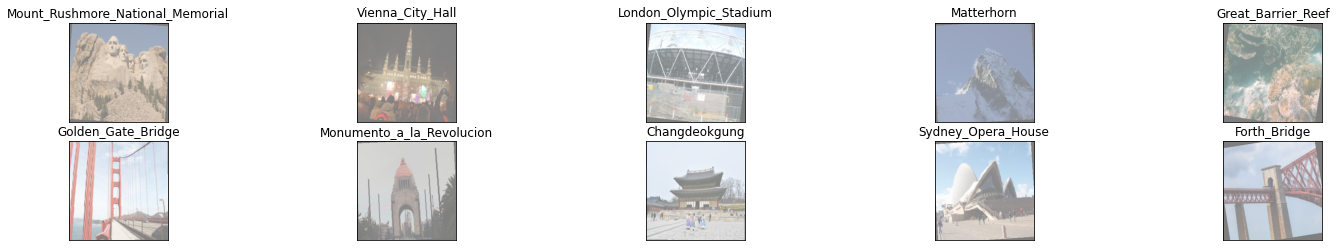

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Visualizing a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of our dataset object (e.g., `train_dataset.classes`)

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# get class names
classes = train_dataset.classes

# helper function
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 10 images -> 1 batch
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]][3:])



### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### Specifying Loss Function and Optimizer

We will use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).

In [4]:
from torch import nn, optim

criterion = nn.NLLLoss()

def get_optimizer(model):
    # select and return an optimizer
    return optim.Adam(model.parameters(), lr=0.0001)
    

### Model Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        # input -> 3, 256, 256
        # in_channels, out_channels, kernel_size 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # input -> 16, 128, 128
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # input -> 32, 64, 64
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # input -> 64, 32, 32
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # output -> 16x16x128
        
        self.pool = nn.MaxPool2d(2, 2)

        # fc layers for classification
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 50)
        # output is 50 class scores
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        # flatten for fc layers
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.fc1(x))
        
        # output layer
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

# instantiate the CNN
model = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model.to('cuda')

<img src='images/conv-layers.PNG' width=90% />
<img src='images/fc-layers.PNG' width=70% />

The number of channels is started low at the beginning aiming for the model to detect low-level features. As the convolutional layers are stacked, the number of filters is increased to detect complex shapes. For this matter, the number of filters 16, 32, 64, and 128 are determined considering classical CNN architectures such as AlexNet, VGG, and ResNet. 

The size of the filters is considered to be small to collect local information as a priority. Kernel size 3 is chosen based on the present successful models. Accordingly, paddings are used to conserve the input size of the images to be the same after the convolutional layers.

RELU activation function is used after each convolutional and fully connected layer to add non-linearity to the network and to help to prevent the exponential growth in the computation required to operate the neural network.

Max pool is used after each convolutional layer to shrink the volume of the parameters in between. The pooling layers are selected to be a max pool that is better at noticing details on a group of pixels. The size of the parameters is aimed to be reduced by a factor of two and therefore kernel size of 2 is used with a stride of 2.

Fully connected layers are chosen to be 2 layers to gradually decrease the input neuron size to the output 50 neuron class probabilities.

The Logsoftmax activation function is used on the output layer to obtain the probabilities using the exponential function later.

#### Calculations to obtain feature map sizes

The formula:

<img src='images/formula.PNG'/> <img src='images/conv.jpg' width=50% />

where,

> N: input size <br>
> F: kernel size <br> 
> S: stride <br>
> P: padding <br>

<img src='images/calcs.PNG' />

### Implementing the Training Algorithm

We will [save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        
        train_accuracy = 0.0
        valid_accuracy = 0.0
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda'), target.to('cuda')
                
            # clear gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(data)
            
            # calculate loss
            loss = criterion(outputs, target)
            
            # backward pass, calculate gradients
            loss.backward()
            
            # update weights
            optimizer.step()
            
            # track loss
            train_loss += loss.item()
            
            # track accuracy
            predictions = torch.argmax(torch.exp(outputs), dim=1)
            train_accuracy += torch.mean((predictions == target).type(torch.FloatTensor)) * 100
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.to('cuda'), target.to('cuda')

            ## update average validation loss
            outputs = model(data)
            
            loss = criterion(outputs, target)
            valid_loss += loss.item()
            
            # track accuracy
            # get predictions
            predictions = torch.argmax(torch.exp(outputs), dim=1)
            valid_accuracy += torch.mean((predictions == target).type(torch.FloatTensor)) * 100
        
        # print training/validation statistics 
        print('Epoch: {} \nTraining Loss: {:.6f} \tValidation Loss: {:.6f}  \
              \nTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(   
            epoch, 
            train_loss / len(train_loader),
            valid_loss / len(valid_loader),
            train_accuracy / len(train_loader),
            valid_accuracy / len(valid_loader)
            ))

        ## if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    return model


### Experimenting with the Weight Initialization

We will use the code cell below to define a custom weight initialization, and then train with our weight initialization for a few epochs.

Later on, we will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
# initialize with normal distribution with [0, y]
# where y is 1 / square root of n 
# & n is the number of input units of the layer
def custom_weight_init(m):
    for layer in m.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            n = layer.in_features if isinstance(layer, nn.Linear) else layer.in_channels * layer.kernel_size[0]
            y = 1 / np.sqrt(n)
            layer.weight.data.normal_(0, y)
            layer.bias.data.fill_(0.0)
    
model.apply(custom_weight_init)
model = train(20, train_loader, valid_loader, model, get_optimizer(model),
                      criterion, use_cuda, 'init.pt')

Epoch: 1 
Training Loss: 3.908885 	Validation Loss: 3.474980                
Training Accuracy: 7.300000 	Validation Accuracy: 12.611111
Epoch: 2 
Training Loss: 3.274164 	Validation Loss: 3.158281                
Training Accuracy: 18.424999 	Validation Accuracy: 20.822222
Epoch: 3 
Training Loss: 2.913533 	Validation Loss: 2.966446                
Training Accuracy: 26.671429 	Validation Accuracy: 24.411110
Epoch: 4 
Training Loss: 2.567579 	Validation Loss: 2.808710                
Training Accuracy: 34.707142 	Validation Accuracy: 30.222221
Epoch: 5 
Training Loss: 2.270782 	Validation Loss: 2.751624                
Training Accuracy: 41.057144 	Validation Accuracy: 32.033333
Epoch: 6 
Training Loss: 1.996726 	Validation Loss: 2.896515                
Training Accuracy: 48.121429 	Validation Accuracy: 29.544443
Epoch: 7 
Training Loss: 1.757394 	Validation Loss: 2.767715                
Training Accuracy: 53.964287 	Validation Accuracy: 31.166668
Epoch: 8 
Training Loss: 1.512068 	

### Training and Validating the Model

In [8]:
num_epochs = 20

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model.apply(default_weight_init)

# train the model
model = train(num_epochs, train_loader, valid_loader, model, get_optimizer(model), 
                      criterion, use_cuda, 'model.pt')

Epoch: 1 
Training Loss: 3.820802 	Validation Loss: 3.640549                
Training Accuracy: 5.250000 	Validation Accuracy: 9.400000
Epoch: 2 
Training Loss: 3.518481 	Validation Loss: 3.380773                
Training Accuracy: 12.121428 	Validation Accuracy: 15.522222
Epoch: 3 
Training Loss: 3.176337 	Validation Loss: 3.183579                
Training Accuracy: 20.196428 	Validation Accuracy: 19.744444
Epoch: 4 
Training Loss: 2.941057 	Validation Loss: 3.041784                
Training Accuracy: 24.996428 	Validation Accuracy: 23.500000
Epoch: 5 
Training Loss: 2.769388 	Validation Loss: 2.956125                
Training Accuracy: 28.396429 	Validation Accuracy: 25.344444
Epoch: 6 
Training Loss: 2.606759 	Validation Loss: 2.899845                
Training Accuracy: 31.410715 	Validation Accuracy: 26.844444
Epoch: 7 
Training Loss: 2.438297 	Validation Loss: 2.841838                
Training Accuracy: 35.260715 	Validation Accuracy: 29.333332
Epoch: 8 
Training Loss: 2.250879 	V

### Testing the Model

In [9]:
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.to('cuda'), target.to('cuda')
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))
test(test_loader, model, criterion, use_cuda)

Test Loss: 2.617909

Test Accuracy: 34% (435/1250)


---
<a id='step2'></a>
## Step 2: Building a CNN to Classify Landmarks using Transfer Learning

We will now use transfer learning to build a CNN that can identify landmarks from images. We will aim to attain at least 60% accuracy on the test set.

### Specifying Data Loaders for the Landmark Dataset

We will use the code cell below to form three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. We wil randomly split the images located at `landmark_images/train` to form the train and validation data loaders, and use the images located at `landmark_images/test` to form the test data loader.

In [11]:
### Writing data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

train_transform = T.Compose([ T.Resize(256),
                              T.CenterCrop(224),
                              T.RandomHorizontalFlip(),
                              T.RandomRotation(10),
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ])

test_transform = T.Compose([ T.Resize(256),
                             T.CenterCrop(224),
                             T.ToTensor(),
                             T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                           ])

# batch size and samplers are same as before

train_dataset = datasets.ImageFolder('./landmark_images/train/', transform=train_transform)
test_dataset = datasets.ImageFolder('./landmark_images/test/', transform=test_transform)

train_loader_transfer = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader_transfer = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader_transfer = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


### Specifying Loss Function and Optimizer

In [12]:
# output of the resnet-18 is output scores
# cross entropy will apply softmax and calculate the loss based on the predictions and probabilities
criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    # only train the parameters with requires_grad set to True
    return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

### Model Architecture

In [13]:
from torchvision import models

model_transfer = models.resnet18(pretrained=True)

# change fully connected layer's number of output classes
model_transfer.fc = nn.Linear(512, 50)

# freeze weights
for ind, layer in enumerate(model_transfer.children()):
    # freeze the parameters except the last sequential layer and fully connected layer 
    if ind < 7:
        for param in layer.parameters():
            param.requires_grad = False

if use_cuda:
    model_transfer = model_transfer.cuda()

<img src='images/resnet.PNG' width=60% /> <img src='images/pytorch-resnet.PNG' width=60% />

For the transfer learning task, the ResNet-18 model is selected. ResNet model is known with the skip connections that gradients can flow directly through the backwards from later layers to initial filters and is considered a state-of-art model. ResNet-18 model is trained on ImageNet with 1000 different class labels. The landmark dataset has 50 class labels with 100 images in each for training. The dataset is considerably really small, therefore overfitting is a concern in this case. To overcome overfitting difficulty, the weights will be held constant for the convolutional layers except for the last sequential module of the model. This is due to the landmark dataset is differing from the data in ImageNet. The edge information and the shape information from the early layers of the convolutional layers can be benefitted and  the last convolutional layer's weights can be updated to learn the new dataset's higher-level features. Since the new dataset is smaller and different from ImageNet, the fully connected layer's output is changed to match the number of classes of the landmark dataset. The weights for the fc layer are randomized. The last sequential layer of the model is trained to be updated and the pretrained weights are used.

### Training and Validating the Model

In [14]:
# train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 5    # train for a few nmuber of epochs to prevent overfitting

model_transfer = train(num_epochs, train_loader_transfer, valid_loader_transfer, 
                       model_transfer, get_optimizer(model_transfer), 
                          criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 
Training Loss: 2.363900 	Validation Loss: 1.343285                
Training Accuracy: 46.378571 	Validation Accuracy: 66.977776
Epoch: 2 
Training Loss: 1.223819 	Validation Loss: 1.082862                
Training Accuracy: 72.328568 	Validation Accuracy: 71.488884
Epoch: 3 
Training Loss: 0.853455 	Validation Loss: 0.957870                
Training Accuracy: 80.699997 	Validation Accuracy: 75.666664
Epoch: 4 
Training Loss: 0.592677 	Validation Loss: 0.955206                
Training Accuracy: 87.542862 	Validation Accuracy: 75.788887
Epoch: 5 
Training Loss: 0.400794 	Validation Loss: 0.980817                
Training Accuracy: 92.324997 	Validation Accuracy: 74.866669


<All keys matched successfully>

### Testing the Model

In [15]:
test(test_loader_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.779947

Test Accuracy: 80% (1000/1250)


---
<a id='step3'></a>
## Step 3: Writing Landmark Prediction Algorithm

Below function `predict_landmarks`, accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [16]:
import cv2
from PIL import Image

def predict_landmarks(img_path, k):
    ## return the names of the top k landmarks predicted by the transfer learned CNN
    
    # load image
    image = Image.open(img_path).convert('RGB')
    
    # transform image and add batch to the image
    image = test_transform(image).unsqueeze(0)
    
    # move the data to GPU
    image = image.to('cuda')
    
    # get prediction of the model
    # Turn off gradients to speed up this part
    with torch.no_grad():
        output = model_transfer(image)
    
    # turn into probailities 
    probabilities = torch.softmax(output, dim=1)
    
    # get top k values' indices
    _, indices = probabilities.topk(k, dim=1)
    
    # process name of the classes if not already
    if train_dataset.classes[0][0].isnumeric():
        train_dataset.classes = [cl[3:].replace('_', ' ') for cl in train_dataset.classes] 
    
    # return names of the landmarks
    predicted_landmarks = [train_dataset.classes[ind] for ind in torch.squeeze(indices)]
    return predicted_landmarks

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Death Valley National Park',
 'Grand Canyon']

Below function `suggest_locations`, accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

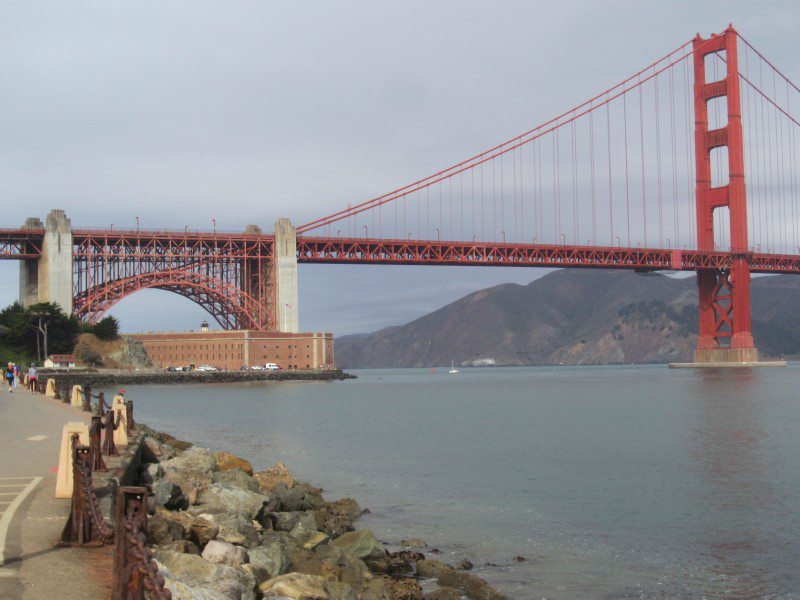

['Golden Gate Bridge', 'Forth Bridge', 'Sydney Harbour Bridge']


In [17]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## display image and display landmark predictions
    im = Image.open(img_path)
    display(im)
    print(predicted_landmarks)    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### Testing the Algorithm

**Possible Improvements** 

 1. It can be experimented further with freezing different set of layers for tuning the best weights for the model.
 2. It can be experimented further with different set of hyperparameters to get the best results.
 3. The number of epochs could be increased and the model could be trained more without overfitting model. 

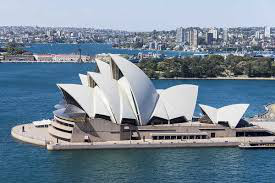

['Sydney Opera House', 'Sydney Harbour Bridge', 'London Olympic Stadium']


In [18]:
suggest_locations('images/test/sydney-2.jpg')

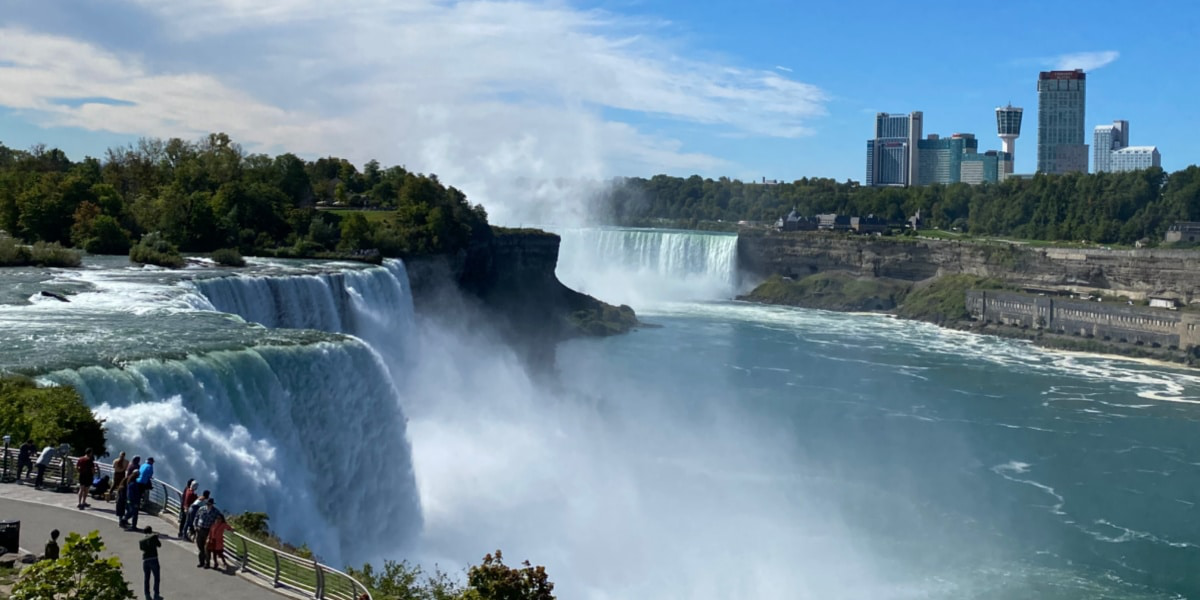

['Niagara Falls', 'Gullfoss Falls', 'Yellowstone National Park']


In [19]:
suggest_locations('images/test/niagara-falls.jpg')

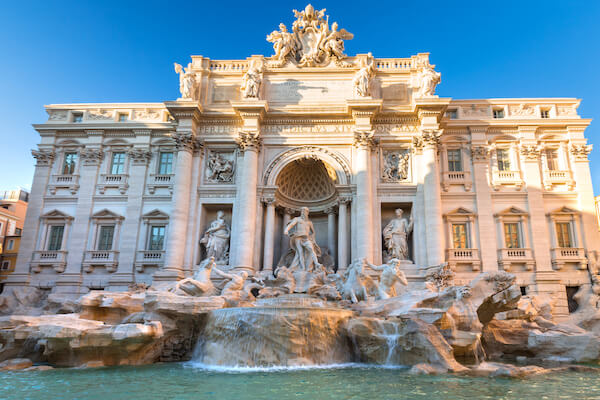

['Trevi Fountain', 'Death Valley National Park', 'Dead Sea']


In [20]:
suggest_locations('images/test/trevi.jpg')